In [65]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [66]:
detectors = ['lowmass', 'highmass1', 'highmass2'] # detectors
codetectors = ['lowmassxhighmass1', 'lowmassxhighmass2', 'highmass1xhighmass2', 'lowmassxhighmass1xhighmass2'] # coincidences
Qs = ['NR', 'ER', 'Ep', 'Eq'] # recoil types; Ep = total phonon ER+NR, Eq = total charge ER+Lindhard(NR)

Ncaptures = {det: 0 for det in detectors} # number of neutron captures in each detector
Nhits = {det: 0 for det in detectors} # total number of entries in trees


# all hits
# all_events[q][d] = histogram of events (true energy) of q recoils in detector d
all_events = {Q: {det: pd.read_csv(
        'analysis_data/' + det + '_evts_' + Q + '.txt', 
        ) for det in detectors} for Q in Qs}

# hits in coincidence with a hit in the lowmass
# coincidence_events[axb][c][q] = histogram of events in detector c that have coincidence in a & b (c must be either a or b) of recoil type q
coincidence_events = {detdet: {det: {Q: pd.read_csv(
            'analysis_data/' + det + '_coinc_' + detdet  + '.txt', 
        ) for Q in Qs
    } for det in detdet.split('x')
} for detdet in codetectors}

# postcapture gammas 
# postcapture_gammas[a][b] -- parent nCapture in a, gamma hit in b -- individual gammas, not event by event
postcapture_gammas = {d1: {d2:  pd.read_csv(
        'analysis_data/' + d1 + '-' + d2 + '_pcg' + '.txt', 
        ) for d2 in detectors} for d1 in detectors}

# define Ebins params
Ebins = all_events['NR']['lowmass']['E'].values
Emin = Ebins[0]
Emax = Ebins[-1] # MeV
Nbins = len(Ebins) - 1

dE = (Ebins[1:] - Ebins[:-1]).mean()
Emids = Ebins + dE/2 # bin centers

In [67]:
def plot_histo(df, ax = None, density = True, **kwargs):
    Es = df['E'].values
    cts = df['count'].values
    if density:
        dE = np.ones(Es.shape)
        dE[:-1] = (Es[1:] - Es[:-1])
        y = cts/dE
    else:
        y = cts
    if ax is None:
        plt.step(Es, y, where = 'post', **kwargs)
    else:
        ax.step(Es, y, where = 'post', **kwargs)

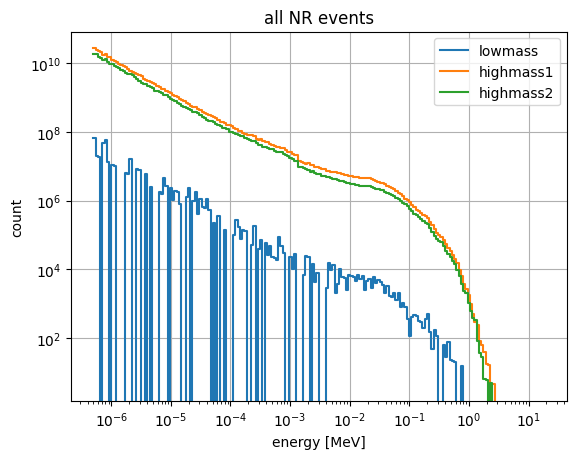

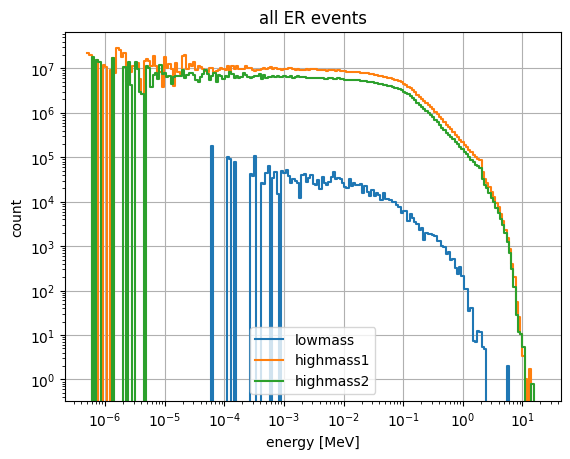

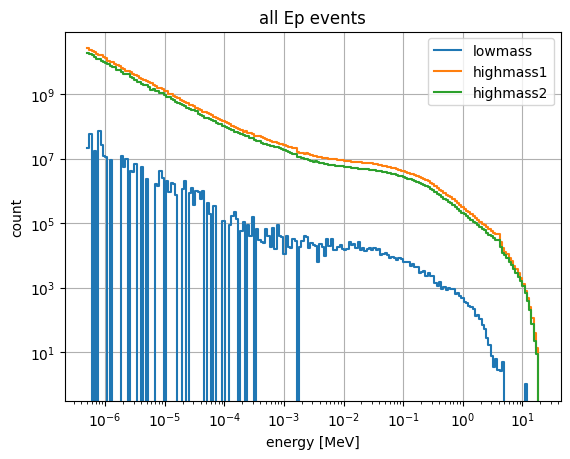

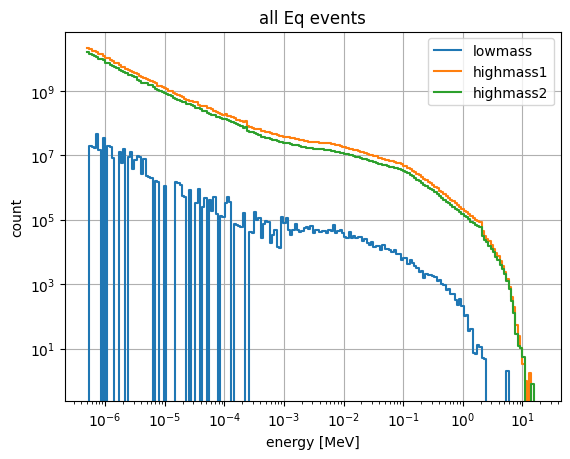

In [68]:
# all events

for Q in Qs:
    plt.figure()
    plt.grid()
    plt.loglog()
    plt.title(f'all {Q} events')
    plt.xlabel('energy [MeV]')
    plt.ylabel('count')

    for det in detectors:
        hist = all_events[Q][det]
        plot_histo(hist, label = det)

    plt.legend()

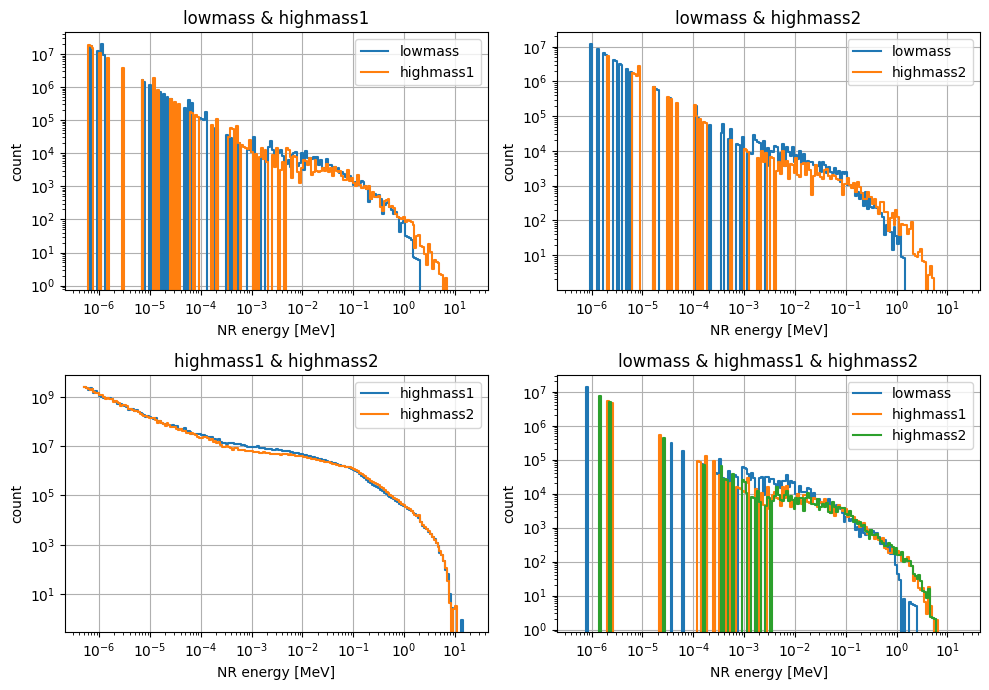

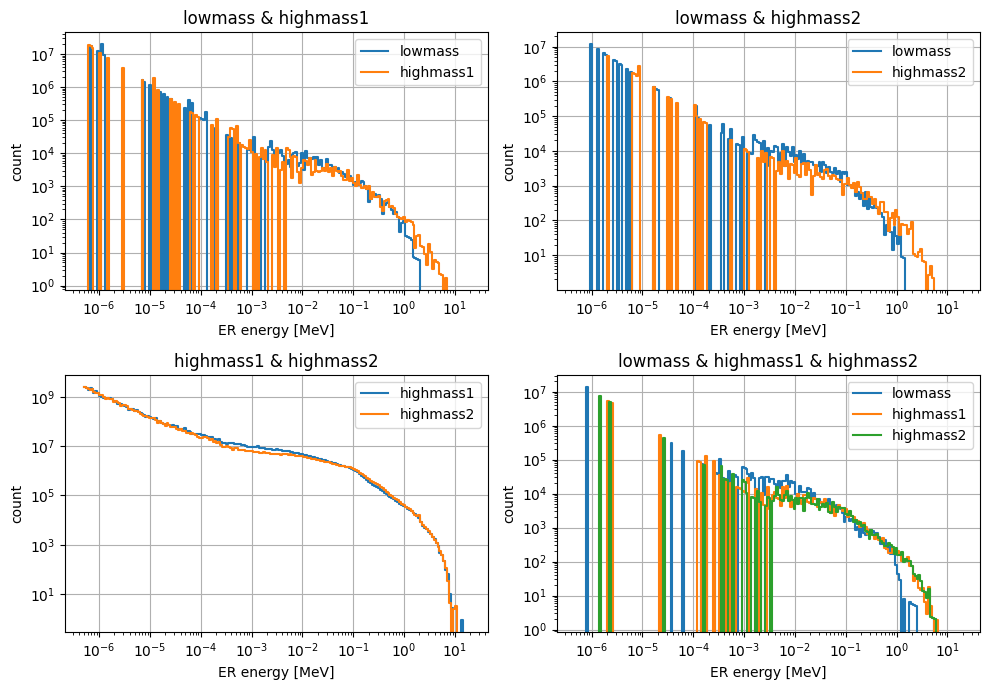

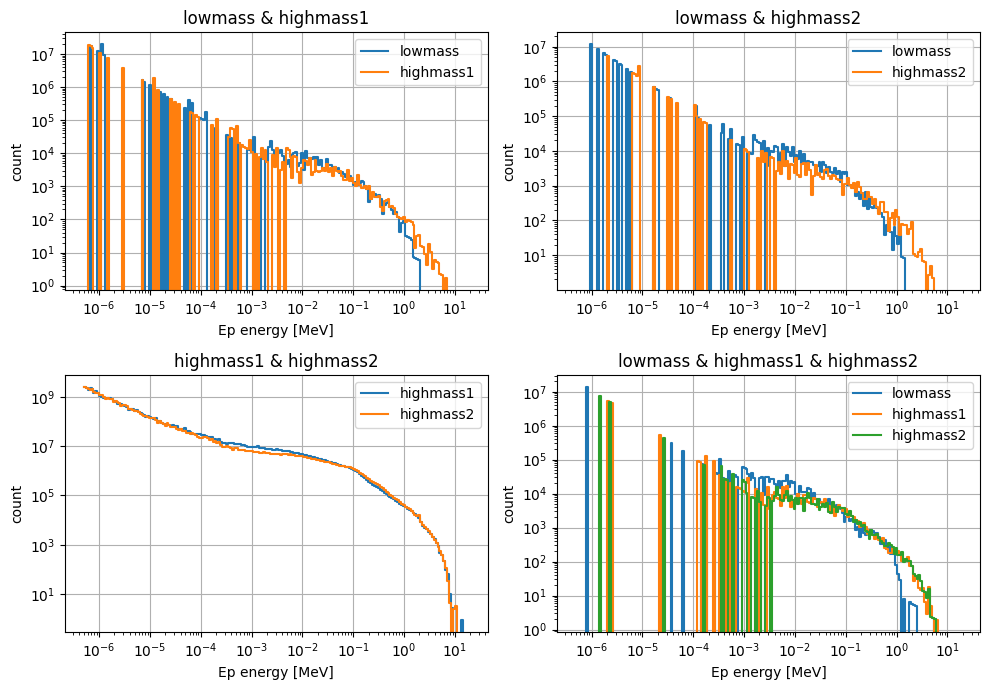

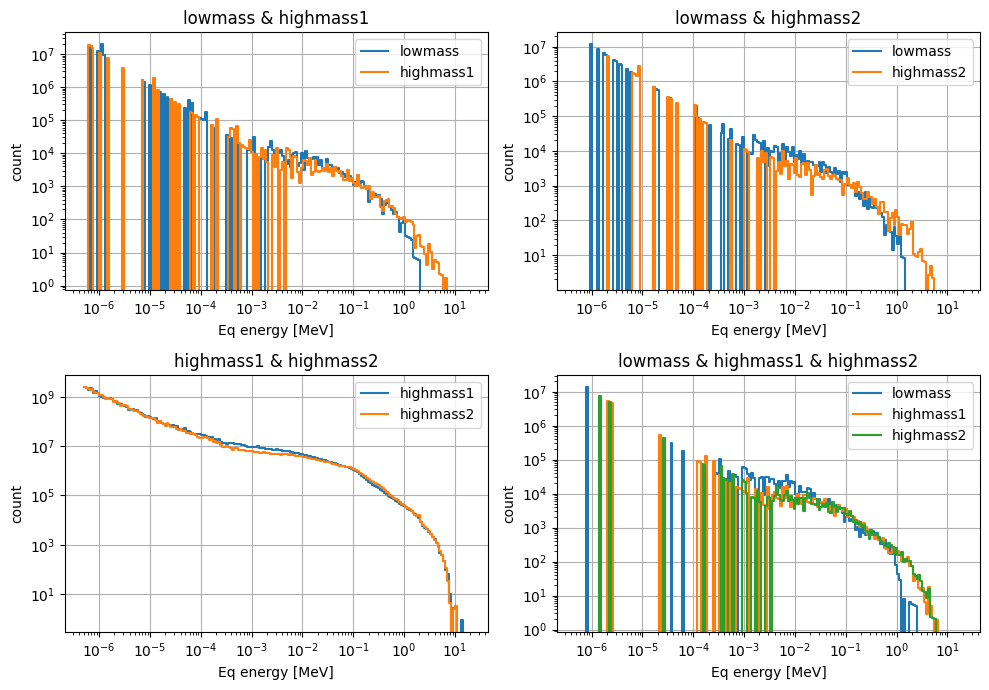

In [69]:
# coincidence events

for Q in Qs:

    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,7))

    for detdet, ax in zip(codetectors, axs.flatten()):
        ax.grid()
        ax.loglog()

        detdetstring = detdet.replace('x', ' & ')
        ax.set_title(f'{detdetstring}')
        
        ax.set_xlabel(f'{Q} energy [MeV]')
        ax.set_ylabel('count')

        for det in detdet.split('x'):
            hist = coincidence_events[detdet][det][Q]
            plot_histo(hist, label = det, ax = ax)

        ax.legend()
    fig.tight_layout()

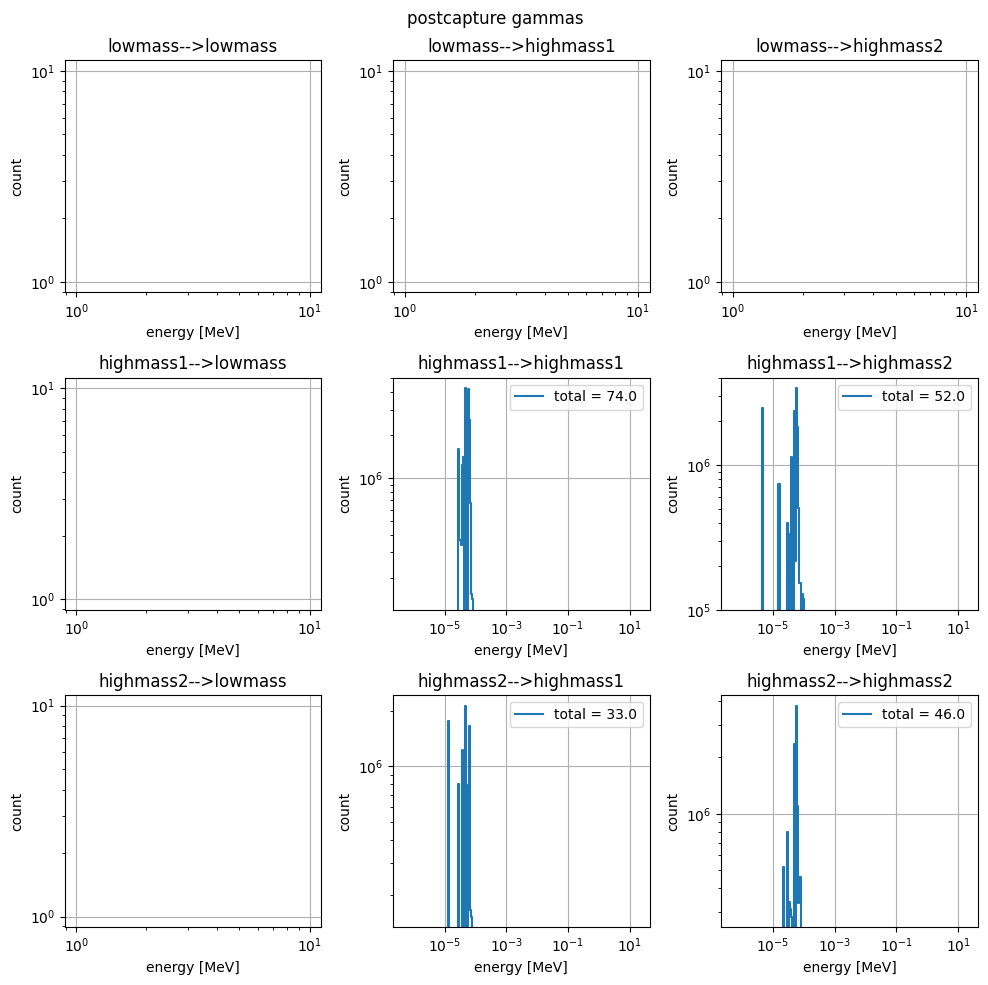

In [70]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (10,10))

fig.suptitle('postcapture gammas')

for i in range(3):
    for j in range(3):

        d1 = detectors[i]
        d2 = detectors[j]
        ax = axs[i,j]

        ax.grid()
        ax.loglog()
        ax.set_title(f'{d1}-->{d2}')
        ax.set_xlabel('energy [MeV]')
        ax.set_ylabel('count')

        hist = postcapture_gammas[d1][d2]
        num = sum(hist["count"])
        if num > 0:
            plot_histo(hist, ax = ax, label = f'total = {num}')

            ax.legend()

fig.tight_layout()

In [71]:
hist['count'].values.sum()

46.0

In [72]:
Emin, Emax, Nbins

(5e-07, 18.33195580955897, 200)